In [72]:

from analyze import analyze_data
from utils import RequestData
import json
from datetime import datetime
from zoneinfo import ZoneInfo
run_log_dir = "/mnt/network_drive/lrq/logs/logs_2025-08-16-17-54-24/run_2"
GRAN = "30s"
memory_metric = "vllm:gpu_cache_usage_perc"
# throughput_metric = f"vllm:avg_generation_throughput_toks_per_s"
metrics_list = [memory_metric]
report_file_path = analyze_data(run_log_dir, metrics_list)
with open(report_file_path, 'r') as f:
    report = json.load(f)

loadgen_data = report['loadgen_data']
total_request_count = len(loadgen_data)
no_response_count = 0
error_count = 0
requests = []
for request_data in loadgen_data:
    if 'error' not in request_data.keys():
        request = RequestData.init_from_dict(request_data)
        requests.append(request)
        continue

    if request_data == {'error': 'No response!'}:
        no_response_count += 1
    else:
        error_count += 1
        print(request_data)

print(f"Total request: {total_request_count}, no response: {no_response_count}, error: {error_count}")
recv_kv_failed_requests = report['recv_failed_requests']
print(f"There are totally {len(recv_kv_failed_requests)} requests fall back to model forwarding!")

start_str = report.get('router_start_time', 'N/A')
end_str = report.get('router_end_time', 'N/A')
tz_sg = ZoneInfo("Asia/Singapore")
router_start_time = datetime.fromisoformat(start_str).replace(tzinfo=tz_sg).timestamp()
router_end_time = datetime.fromisoformat(end_str).replace(tzinfo=tz_sg).timestamp()
print(f"Router start time: {router_start_time}, end time: {router_end_time}")

import re
tz_sg = ZoneInfo("Asia/Singapore")
pattern = re.compile(r"^(\d{4}/\d{2}/\d{2} \d{2}:\d{2}:\d{2}) Finished preparing http requests")

with open(f"{run_log_dir}/loadgen.err") as f:
    for line in f:
        m = pattern.match(line)
        if m:
            dt = datetime.strptime(m.group(1), "%Y/%m/%d %H:%M:%S").replace(tzinfo=tz_sg)
            break

first_request_sendtime = dt.timestamp() + 5 - router_start_time
spike_start_time = first_request_sendtime + 30
print(f"first request is sent out at: {first_request_sendtime}s, spike starts at: {spike_start_time}s")

Starting Prometheus...


ts=2025-08-16T11:46:25.232Z caller=main.go:573 level=info msg="No time or size retention was set so using the default time retention" duration=15d
ts=2025-08-16T11:46:25.232Z caller=main.go:617 level=info msg="Starting Prometheus Server" mode=server version="(version=2.52.0, branch=HEAD, revision=879d80922a227c37df502e7315fad8ceb10a986d)"
ts=2025-08-16T11:46:25.232Z caller=main.go:622 level=info build_context="(go=go1.22.3, platform=linux/amd64, user=root@1b4f4c206e41, date=20240508-21:56:43, tags=netgo,builtinassets,stringlabels)"
ts=2025-08-16T11:46:25.232Z caller=main.go:623 level=info host_details="(Linux 5.4.0-216-generic #236-Ubuntu SMP Fri Apr 11 19:53:21 UTC 2025 x86_64 f7f2947b0d8a (none))"
ts=2025-08-16T11:46:25.232Z caller=main.go:624 level=info fd_limits="(soft=1048576, hard=1048576)"
ts=2025-08-16T11:46:25.232Z caller=main.go:625 level=info vm_limits="(soft=unlimited, hard=unlimited)"
ts=2025-08-16T11:46:25.240Z caller=web.go:568 level=info component=web msg="Start listeni

Running Python app...
query_metrics_list: ['vllm:gpu_cache_usage_perc']
params_list: [{'query': 'vllm:gpu_cache_usage_perc', 'start': '2025-08-16T09:56:10Z', 'end': '2025-08-16T11:56:10Z', 'step': '1s'}]
Total request: 60, no response: 0, error: 0
There are totally 0 requests fall back to model forwarding!
Router start time: 1755338100.292173, end time: 1755338292.861115
first request is sent out at: 74.70782709121704s, spike starts at: 104.70782709121704s


In [73]:
import matplotlib.pyplot as plt
from datetime import datetime
def add_metric_plot(metrics, metric_name: str, ax, color, ylabel):
    series = metrics.get(metric_name, [])
    times = [datetime.utcfromtimestamp(float(t[0])) for t in series]
    values = [float(t[1]) for t in series]
    if times == []:
        return
    sorted_pairs = sorted(zip(times, values))
    times_sorted, values_sorted = zip(*sorted_pairs)
    times_offset = [t.timestamp() - router_start_time for t in times_sorted]

    ax.plot(times_offset, values_sorted, color=color)
    ax.set_ylabel(ylabel, color=color)

In [74]:

import os
from datetime import datetime
from datetime import timezone, timedelta
import numpy as np

# Read the log file
file_path = os.path.join(run_log_dir, "worker_0.err")  # Enter your file path here
with open(file_path, 'r') as file:
    lines = file.readlines()

# Pattern to match the log entries
pattern = r'\[(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3})\].*?Total allocated size: ([\d.]+) MB.*?put_speed: ([\d.]+) obj/s.*?get_speed: ([\d.]+) obj/s'

# Extract data
timestamps = []
allocated_sizes = []
put_speeds = []
get_speeds = []

OBJ_SIZE = 256

for line in lines:
    match = re.search(pattern, line)
    if match:
        timestamp_str = match.group(1)
        timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S,%f')
        # Attach Singapore timezone (UTC+8)
        sg_timezone = timezone(timedelta(hours=8))
        timestamp = timestamp.replace(tzinfo=sg_timezone)
        timestamps.append(timestamp)
        allocated_sizes.append(float(match.group(2)))
        put_speeds.append(float(match.group(3))*OBJ_SIZE)
        get_speeds.append(float(match.group(4))*OBJ_SIZE)

# Calculate time offsets from the minimum timestamp
time_offsets = [t.timestamp() - router_start_time for t in timestamps]

TIME_WINDOW = 1

# Lists to store event timestamps when requests are completed
decode_times = []

# Fill in event lists with only SLO-satisfying requests
finished_tokens = []
prefill_tokens = []
decode_tokens = []
tpots = []
for request_data in loadgen_data:
    if 'error' in request_data:
        continue

    request = RequestData.init_from_dict(request_data)

    arrival_time = request.arrival_time
    decode_finished_time = arrival_time + request.ttft + request.waiting_latency + request.decode_latency


    decode_times.append(decode_finished_time)
    finished_tokens.append(request.decode_tokens+request.prompt_tokens)
    prefill_tokens.append(request.prompt_tokens)
    decode_tokens.append(request.decode_tokens)
    tpot = request.decode_latency / request.decode_tokens if request.decode_tokens > 0 else 0
    tpots.append(tpot)

assert len(decode_times) == len(finished_tokens)

# Step 1: Normalize decode_times to time offsets from base_time
# Assume decode_times[0] is a float Unix timestamp
ts = decode_times[0]

# Define Singapore timezone (UTC+8)
from datetime import datetime, timezone, timedelta
sg_timezone = timezone(timedelta(hours=8))

# Convert to datetime with Singapore timezone
dt_sg = datetime.fromtimestamp(ts, tz=sg_timezone)

# Print it
time_offsets = [t - router_start_time for t in decode_times]

# Step 2: Bucket the values into fixed-size time windows
max_time = max(time_offsets)
num_windows = int(np.ceil(max_time / TIME_WINDOW))
print(f"Number of time windows: {num_windows}")

window_edges = [i * TIME_WINDOW for i in range(num_windows + 1)]
window_avgs = []
window_centers = []
r_avgs = []
tpot_avgs = []

for i in range(num_windows):
    start = window_edges[i]
    end = window_edges[i + 1]

    # Gather tokens in this time window
    tokens_in_window = [
        tok  for t, tok in zip(time_offsets, finished_tokens)
        if start <= t < end
    ]
    prefill_toks_in_window = [
        tok  for t, tok in zip(time_offsets, prefill_tokens)
        if start <= t < end
    ]

    decode_toks_in_window = [
        tok  for t, tok in zip(time_offsets, decode_tokens)
        if start <= t < end
    ]

    tpot_in_window = [
        tpot for t, tpot in zip(time_offsets, tpots)
        if start <= t < end
    ]

    if tokens_in_window:
        avg = sum(tokens_in_window) / TIME_WINDOW
        r = np.mean(np.asarray(prefill_toks_in_window) / np.array(decode_toks_in_window))
    else:
        r = 0
        avg = 0

    window_avgs.append(avg)
    r_avgs.append(r)
    tpot_avgs.append(np.mean(tpot_in_window) if tpot_in_window else 0)
    # window_centers.append((start + end) / 2)
    window_centers.append(end)

Number of time windows: 139


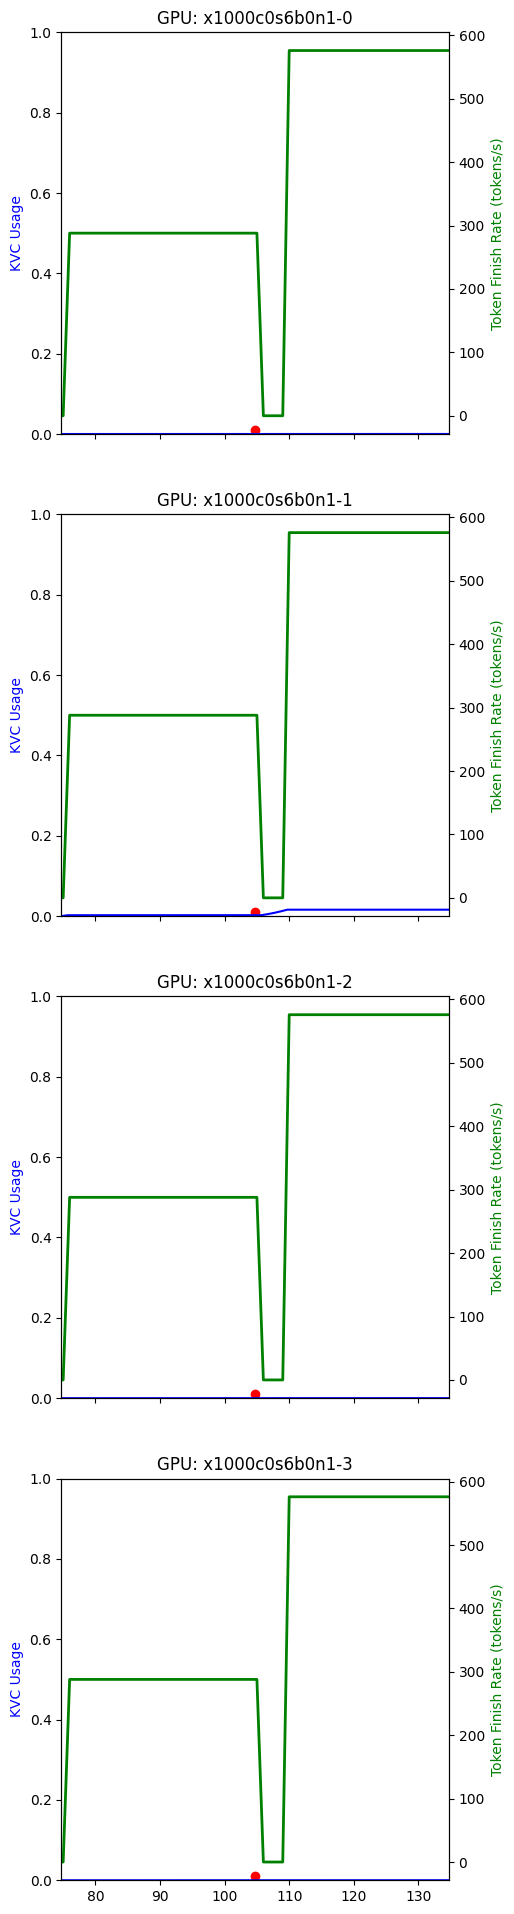

In [75]:
data = report['prom_data'].copy()
del data['router']
num_instances = 4
fig, axes = plt.subplots(4, 1, figsize=(5, 24), sharex=True)
for ax, (instance_uuid, metrics) in zip(axes, data.items()):

    add_metric_plot(metrics, memory_metric, ax, color="blue", ylabel="KVC Usage")
    ax.set_ylim([0,1])
    ax.set_title(f"GPU: {instance_uuid}")
    ax.scatter(spike_start_time, 0.01, color='red', label='Spike Start')
    ax.set_xlim([first_request_sendtime, spike_start_time+30])
    ax2 = ax.twinx()
    ax2.plot(window_centers, window_avgs, color='green', label='Token Finish Rate', linewidth=2)
    ax2.set_ylabel("Token Finish Rate (tokens/s)", color='green')


Text(0, 0.5, 'Token Finish Rate (tokens/s)')

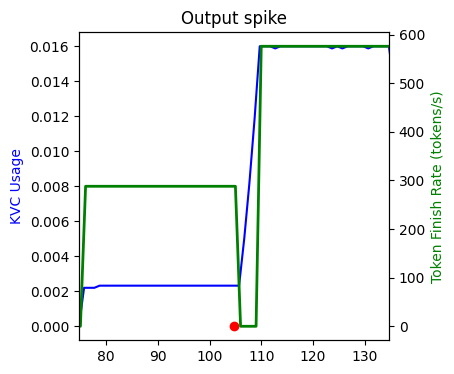

In [77]:
DECODER_INSTANCE_ID = "1"
TITLE= "Output spike"
data = report['prom_data'].copy()
del data['router']
instance_uuid = ""
for decoder_instance in data.keys():
    if decoder_instance.endswith(DECODER_INSTANCE_ID):
        instance_uuid = decoder_instance
# fig, axes = plt.subplots(4, 1, figsize=(5, 24), sharex=True)
metrics = data[instance_uuid]

fig, ax = plt.subplots(figsize=(4,4))
add_metric_plot(metrics, memory_metric, ax, color="blue", ylabel="KVC Usage")
# ax.set_ylim([0,1])
ax.set_title(TITLE)
ax.scatter(spike_start_time, 0, color='red', label='Spike Start')
ax.set_xlim([first_request_sendtime, spike_start_time+30])
ax2 = ax.twinx()
ax2.plot(window_centers, window_avgs, color='green', label='Token Finish Rate', linewidth=2)
ax2.set_ylabel("Token Finish Rate (tokens/s)", color='green')